In [1]:
!#cd ..; python3 python/scripts/preprocess_bgl3.py

In [2]:
# general imports
import random
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from utils import mutate_wt, truncate_seq_from_asterisk_onwards

In [4]:
# suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# imports for machine learning
import tensorflow as tf
import keras.utils
from keras import objectives
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

# imports for visualization
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [5]:
single_mutation_file = "../data/working/Bgl3_single_mutations.tsv"
double_mutation_file = "../data/working/Bgl3_double_mutations.tsv"

In [6]:
single_mutations = pd.read_csv(single_mutation_file, sep="\t")
double_mutations = pd.read_csv(double_mutation_file, sep="\t")

In [7]:
single_mutations.describe()[:1]

,Unnamed: 0,positive,unsorted,positive_hitemp
count,5573.0,4522.0,4435.0,4054.0


In [8]:
double_mutations.describe()[:1]

,Unnamed: 0,positive,unsorted,positive_hitemp
count,523013.0,202618.0,263530.0,198481.0


In [9]:
# Set up constants for wild type and alphabets
WT_Bgl3 = 'MVPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSIWDTYARTPGRVRNGDTGDVATDHYHRWREDVALMAELGLGAYRFSLAWPRIQPTGRGPALQKGLDFYRRLADELLAKGIQPVATLYHWDLPQELENAGGWPERATAERFAEYAAIAADALGDRVKTWTTLNEPWCSAFLGYGSGVHAPGRTDPVAALRAAHHLNLGHGLAVQALRDRLPADAQCSVTLNIHHVRPLTDSDADADAVRRIDALANRVFTGPMLQGAYPEDLVKDTAGLTDWSFVRDGDLRLAHQKLDFLGVNYYSPTLVSEADGSGTHNSDGHGRSAHSPWPGADRVAFHQPPGETTAMGWAVDPSGLYELLRRLSSDFPALPLVITENGAAFHDYADPEGNVNDPERIAYVRDHLAAVHRAIKDGSDVRGYFLWSLLDNFEWAHGYSKRFGAVYVDYPTGTRIPKASARWYAEVARTGVLPTAGDPNSSSVDKLAAALEHHHHHH*'
# Remove the asterisk at the end
WT_Bgl3 = np.array(list(truncate_seq_from_asterisk_onwards(WT_Bgl3)))

# Find all the unique letters
ALPHABET = np.array([l for l in set(WT_Bgl3) if l != "*"])
ALPHABET.sort()
ALPHABET_SIZE = len(ALPHABET)
print("ALPHABET =", ALPHABET)
print("ALPHABET_SIZE =", ALPHABET_SIZE)

WT_SIZE = len(WT_Bgl3)
print("WT_SIZE = ", WT_SIZE)

# This is an integer representation of the WT (index positions of the ALPHABET)
WT_INDEX = ALPHABET.searchsorted(WT_Bgl3)
print("WT       (first few elements) = ", WT_Bgl3[:15])
print("WT_INDEX (first few elements) = ", WT_INDEX[:15])

ALPHABET = ['A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'V'
 'W' 'Y']
ALPHABET_SIZE = 20
WT_SIZE =  501
WT       (first few elements) =  ['M' 'V' 'P' 'A' 'A' 'Q' 'Q' 'T' 'A' 'M' 'A' 'P' 'D' 'A' 'A']
WT_INDEX (first few elements) =  [10 17 12  0  0 13 13 16  0 10  0 12  2  0  0]


In [10]:
# Lets do a couple of mutations and check
print("Wildtype Index (first few elements) :", WT_INDEX[:10])
print("Mutated Index  (first few elements) :", mutate_wt(WT_INDEX, ALPHABET, "A4F", "A5L")[:10])

Wildtype Index (first few elements) : [10 17 12  0  0 13 13 16  0 10]
Mutated Index  (first few elements) : [10 17 12  4  9 13 13 16  0 10]


### Construct training data

In [11]:
wt_one_hot = keras.utils.to_categorical(WT_INDEX, ALPHABET_SIZE)
print("Wild Type One Hot\n", wt_one_hot)
print("Wild Type One Hot Shape", wt_one_hot.shape)
print("Wild Type One Hot Flattened Shape", wt_one_hot.flatten().shape)

Wild Type One Hot
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Wild Type One Hot Shape (501, 20)
Wild Type One Hot Flattened Shape (10020,)


In [12]:
# filter out mutations that have an asterisk in them. 
# Also keep only positive mutations
single_positive_mutations = single_mutations.mutations[ (~ single_mutations.mutations.str.contains("*", regex=False)) & 
                               (single_mutations.positive == 1.0) ]

single_positive_mutations.head()

1    A104D
2    A104E
3    A104G
4    A104K
5    A104P
Name: mutations, dtype: object

In [13]:
double_positive_mutations =  double_mutations.mutations[ (~ double_mutations.mutations.str.contains("*", regex=False)) & 
                               (double_mutations.positive == 1.0) ]
double_positive_mutations.head()

0    A104D,N383K
1    A104E,A142E
2    A104E,A155S
3    A104E,A158V
4    A104E,E147D
Name: mutations, dtype: object

In [14]:
# Create a list of positive mutations
positive_mutations = list(single_positive_mutations) + list(double_positive_mutations)
print("Number of positive mutations : ", len(positive_mutations))
sample_size = 15000
positive_mutations = random.sample(positive_mutations, sample_size)

Number of positive mutations :  196281


In [15]:
training_data = np.vstack(
    (keras.utils.to_categorical(
        mutate_wt(WT_INDEX, ALPHABET, *mut.split(",")), ALPHABET_SIZE).flatten() for mut in positive_mutations))

training_data.shape

(15000, 10020)

### Construct the AutoEncoder Model

[VAE code taken from keras example](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py)

In [16]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [17]:
# network parameters
original_dim = WT_SIZE * ALPHABET_SIZE
input_shape = (original_dim, )
intermediate_dim = 256
batch_size = 20
latent_dim = 2
epochs = 10
np.random.seed(1)

In [18]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 10020)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          2565376     encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

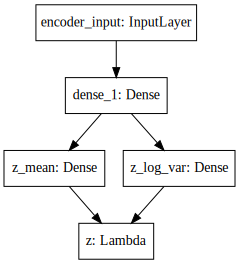

In [19]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
SVG(model_to_dot(encoder).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               768       
_________________________________________________________________
dense_3 (Dense)              (None, 10020)             2575140   
Total params: 2,575,908
Trainable params: 2,575,908
Non-trainable params: 0
_________________________________________________________________


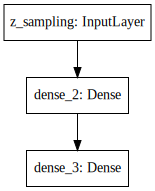

In [20]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
SVG(model_to_dot(decoder).create(prog='dot', format='svg'))

In [21]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [22]:
# VAE loss
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 10020)             0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 2566404   
_________________________________________________________________
decoder (Model)              (None, 10020)             2575908   
Total params: 5,142,312
Trainable params: 5,142,312
Non-trainable params: 0
_________________________________________________________________


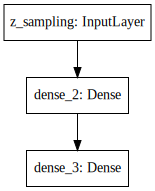

In [23]:
vae.compile(optimizer='adam', loss=vae_loss)
vae.summary()
SVG(model_to_dot(decoder).create(prog='dot', format='svg'))

### Run the AutoEncoder model

In [24]:
vae.fit(training_data, training_data, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Train on 13500 samples, validate on 1500 samples
Epoch 1/10
13500/13500 [==============================] - 140s 10ms/step - loss: 159.9978 - val_loss: 38.2074
Epoch 2/10
13500/13500 [==============================] - 127s 9ms/step - loss: 34.3846 - val_loss: 32.4427
Epoch 3/10
13500/13500 [==============================] - 127s 9ms/step - loss: 31.1411 - val_loss: 30.6508
Epoch 4/10
13500/13500 [==============================] - 122s 9ms/step - loss: 29.8915 - val_loss: 30.2779
Epoch 5/10
13500/13500 [==============================] - 123s 9ms/step - loss: 29.2629 - val_loss: 29.3648
Epoch 6/10
13500/13500 [==============================] - 121s 9ms/step - loss: 28.8836 - val_loss: 29.0350
Epoch 7/10
13500/13500 [==============================] - 125s 9ms/step - loss: 28.6520 - val_loss: 28.8875
Epoch 8/10
13500/13500 [==============================] - 141s 10ms/step - loss: 28.4051 - val_loss: 28.6359
Epoch 9/10
13500/13500 [==============================] - 120s 9ms/step - loss: 28.0

In [25]:
training_data_encoded = encoder.predict(training_data, batch_size=batch_size)
training_data_encoded[0].shape

(15000, 2)

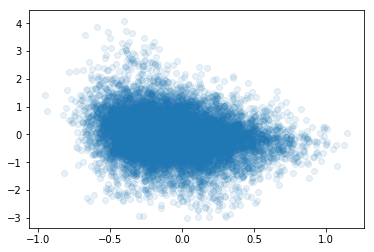

In [26]:
# Visualize latent space
plt.scatter(training_data_encoded[0][:, 0], training_data_encoded[0][:, 1], alpha=0.1)